<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

## Initialization

In [1]:
IS_COLAB = False

In [2]:
%load_ext autoreload
%autoreload 2

In [111]:
import os, sys, re, json
import string
import torch
import numpy as np

import copy
from collections import defaultdict, Counter
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

import random
import matplotlib.pyplot as plt
import sqlite3
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
torch.set_grad_enabled(False)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
from transformers import (
    HfArgumentParser,
    set_seed,
    AutoTokenizer
)

# from uskg.models.unified.prefixtuning import Model
from uskg.models.unified import finetune, prefixtuning
from uskg.utils.configue import Configure
from uskg.utils.training_arguments import WrappedSeq2SeqTrainingArguments
from uskg.seq2seq_construction import spider as s2s_spider
from uskg.third_party.spider.preprocess.get_tables import dump_db_json_schema
from uskg.third_party.spider import evaluation as sp_eval
from tqdm.notebook import tqdm

# from nltk.stem.wordnet import WordNetLemmatizer
# import stanza
from experiments import causal_trace_uskg as ctu

In [7]:
mt_uskg = ctu.ModelAndTokenizer_USKG('t5-large-prefix')

Using tokenizer_uskg: hkunlp/from_all_T5_large_prefix_spider_with_cell_value2
Using tokenizer_fast: t5-large
prefix-tuning sequence length is 10.


In [8]:
list(mt_uskg.task_args.seq2seq)

[('constructor', 'seq2seq_construction.spider'),
 ('schema_serialization_with_db_content', True),
 ('target_with_db_id', False)]

In [9]:
mt_uskg.model.pretrain_model.encoder.embed_tokens is mt_uskg.model.pretrain_model.shared, \
mt_uskg.model.pretrain_model.decoder.embed_tokens is mt_uskg.model.pretrain_model.shared

(True, False)

In [10]:
mt_uskg.model.preseqlen

10

In [167]:
# [k for k,v in mt_uskg.model.named_parameters()]
[k for k,v in mt_uskg.model.named_modules()][-50:]

['pretrain_model.decoder.block.22.layer.2.DenseReluDense',
 'pretrain_model.decoder.block.22.layer.2.DenseReluDense.wi',
 'pretrain_model.decoder.block.22.layer.2.DenseReluDense.wo',
 'pretrain_model.decoder.block.22.layer.2.DenseReluDense.dropout',
 'pretrain_model.decoder.block.22.layer.2.layer_norm',
 'pretrain_model.decoder.block.22.layer.2.dropout',
 'pretrain_model.decoder.block.23',
 'pretrain_model.decoder.block.23.layer',
 'pretrain_model.decoder.block.23.layer.0',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.q',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.k',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.v',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.o',
 'pretrain_model.decoder.block.23.layer.0.layer_norm',
 'pretrain_model.decoder.block.23.layer.0.dropout',
 'pretrain_model.decoder.block.23.layer.1',
 'pretrain_model.decoder.block.23.layer.1.EncDecAttention',
 'pretrain_m

## Data

### Load spider dataset

In [12]:
spider_train_path = '/home/yshao/Projects/SDR-analysis/data/spider/train+ratsql_graph.json'
spider_dev_path = '/home/yshao/Projects/SDR-analysis/data/spider/dev+ratsql_graph.json'
spider_db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [13]:
raw_spider_dev = ctu.load_raw_dataset(
    data_filepath = spider_dev_path,
    db_path=spider_db_dir,
#     schema_cache=SCHEMA_CACHE
)
len(raw_spider_dev)

1034

In [14]:
raw_spider_dev[0].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph'])

In [15]:
mt_uskg.task_args.dataset.use_cache

True

In [16]:
processed_spider_dev = s2s_spider.DevDataset(
    args=mt_uskg.task_args,
    raw_datasets=raw_spider_dev,
    cache_root='../cache')

In [17]:
_id = 130
processed_spider_dev[_id]['text_in'], \
processed_spider_dev[_id]['struct_in'], \
processed_spider_dev[_id]['seq_out']

('What are the names of all European countries with at least 3 manufacturers?',
 '| car_1 | continents : contid , continent ( europe ) | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.countryname from countries as t1 join continents as t2 on t1.continent = t2.contid join car_makers as t3 on t1.countryid = t3.country where t2.continent = 'europe' group by t1.countryname having count(*) >= 3;")

In [18]:
_enc_sentence = f"{processed_spider_dev[_id]['text_in']}; structed knowledge: {processed_spider_dev[_id]['struct_in']}"
_toks = mt_uskg.tokenizer.tokenize(_enc_sentence)
len(_toks)

142

In [19]:
# # _occ_punct = set()

# for _id in range(len(processed_spider_dev)):
#     ex = processed_spider_dev[_id]
# #     _occ_punct.update(set(string.punctuation) & set(ex['seq_out']))
#     if '_(' in ex['struct_in']:
#         print(_id, ex['question'])
#         print(ex['struct_in'])
#         print(ex['seq_out'])
#         print()

In [20]:
# ## Train set

# raw_spider_train = ctu.load_raw_dataset(
#     data_filepath = spider_train_path,
#     db_path=spider_db_dir,
# )
# processed_spider_train = s2s_spider.TrainDataset(
#     args=mt_uskg.task_args,
#     raw_datasets=raw_spider_train,
#     cache_root='../cache')
# len(processed_spider_train)

In [21]:
# processed_spider_train[5441]

### Helpers
- Aspects-related helpers are merged into create_analysis_sample_dicts()

#### Utils

In [22]:
def exp6_ob_by_exp_tok(samples):
    # samples: usually `good_samples`
    
    # Key: (expect_tok, sect_k, layer) -> [scores]
    trace_scores_by_exp_tok = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    trace_scores_avg_by_exp_tok = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    trace_scores_cnt_by_exp_tok = defaultdict(int)  # no sect key & layer key 

    trace_sample_ids_by_exp_tok = defaultdict(list)
    
    for i, d in enumerate(samples):
        expect = d['expect']
        trace_sample_ids_by_exp_tok[expect].append(i)
        for sect_k, sect_d in d['trace_scores'].items():
            for layer_k, v in sect_d.items():
                trace_scores_by_exp_tok[expect][sect_k][layer_k].append(v)

    for exp_tok, d1 in trace_scores_by_exp_tok.items():
        if exp_tok.isnumeric(): continue
        for sect_k, d2 in d1.items():
            for layer_k, scores in d2.items():
                if len(scores) <= 2: continue
                trace_scores_avg_by_exp_tok[exp_tok][sect_k][layer_k] = np.mean(scores)
                trace_scores_cnt_by_exp_tok[exp_tok] = len(scores)
    
    return {
        'avg': trace_scores_avg_by_exp_tok,
        'cnt': trace_scores_cnt_by_exp_tok,
        'sample_ids': trace_sample_ids_by_exp_tok,
    }

In [23]:
def reverse_2D_dict(d):
    out_d = defaultdict(lambda: defaultdict(np.nan))
    for k1, d1 in d.items():
        for k2, v in d1.items():
            out_d[k2][k1] = v
    return out_d

def format_print_1D_dict(d, sort_by=None, reverse=False, head_col_w=10, col_w=6):
    # sort: None, 'key' or 'value'
    
    item_l = list(d.items())
    if sort_by == 'key':
        item_l.sort(reverse=reverse)
    elif sort_by == 'value':
        item_l.sort(key=lambda x: (x[1], x[0]), reverse=reverse)
    
    decm_w = col_w - 2
    
    for k, v in item_l:
        print(f'{k:<{head_col_w}s}{v:.{decm_w}f}')

def format_print_2D_dict(d, 
                         all_k1=None, 
                         all_k2=None, 
                         sort_k1_kwargs=None, 
                         sort_k2_kwargs=None, 
                         head_col_w=12, 
                         col_w=6,
                         decm_w=4):
    if all_k1 is None:
        all_k1 = list(d.keys())
        if sort_k1_kwargs is not None:
            all_k1.sort(**sort_k1_kwargs)
    
    if all_k2 is None:
        for k1, d1 in d.items():
            d1_keys = list(d1.keys())
            if all_k2 is None:
                all_k2 = d1_keys
            else:
                if set(d1_keys) != set(all_k2):
                    print('Warning:\n', d1_keys, '\n', all_k2)
            # all_k2.update(list(d1.keys()))
        if sort_k2_kwargs is not None:
            all_k2.sort(**sort_k2_kwargs)
    
    print_str = '\t'.join(['X' * head_col_w] + [f'{k2:<{col_w}s}' for k2 in all_k2]) + '\n'
    
    for k1 in all_k1:
        d1 = d[k1]
        print_str += f'{k1:<{head_col_w}s}'
        for k2 in all_k2:
            v = d1[k2]
            print_str += f'\t{v:<{col_w}.{decm_w}f}'
        print_str += '\n'
    
    print(print_str)

In [171]:
def untuple(x):
    if isinstance(x, tuple):
        return x[0]
    else:
        return x

#### Evaluator

In [24]:
table_path = '/home/yshao/Projects/language/language/xsp/data/spider/tables.json'
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [25]:
kmaps = sp_eval.build_foreign_key_map_from_json(table_path)
evaluator = sp_eval.Evaluator(db_dir=db_dir, kmaps=kmaps, etype='all')

In [26]:
ctu.evaluate_hardness.evaluator = evaluator

In [27]:
# test
_sql_str = 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1'
db_name = 'poker_player'
schema = evaluator.schemas[db_name]
_sql = sp_eval.get_sql(schema, _sql_str)
sp_eval.count_component1(_sql), sp_eval.count_component2(_sql), sp_eval.count_others(_sql), \
evaluator.eval_hardness(_sql)

(3, 0, 0, 'hard')

### Exp-7.0: layer skipping
- Including 7.0.[0-3]

#### Load & Check

In [ ]:
# expect_type = 'table_alias'

# res_path = f'/home/yshao/Projects/rome/results/exp7_0_1_decoder_layer_skip_effect/exp=7.0.1_dev_{expect_type}.jsonl'

res_path = f'/home/yshao/Projects/rome/results/exp7_0_3_decoder_syntax_layer_skip_effect/exp=7.0.3_dev.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

In [ ]:
total_samples = 0
n_good_samples = 0
n_too_hard = 0      # wrong answer 
n_too_easy = 0      # base - low < 0.5

In [ ]:
good_samples = []
bad_samples = []

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        total_samples += 1

        if d.get('is_good_sample', True):
            n_good_samples += 1
            d['ex_id'] = i
            good_samples.append(d)
        elif not d['correct_prediction']:
            n_too_hard += 1
            bad_samples.append(d)
        else:
            assert d['base_score'] - d['low_score'] < 0.5
            n_too_easy += 1
            bad_samples.append(d)
            
total_samples, (n_good_samples, len(good_samples)), n_too_hard, n_too_easy, len(bad_samples), \
f'good / correct = {n_good_samples} / {n_good_samples + n_too_easy}'

#### Overall avg

In [ ]:
trace_scores_avg = {sect_k : defaultdict(int) for sect_k in good_samples[0]['trace_scores'].keys()}

for d in good_samples:
    for sect_k, sect_d in d['trace_scores'].items():
        for k, v in sect_d.items():
            trace_scores_avg[sect_k][k] += v

for sect_k, sect_d in trace_scores_avg.items():
    for k, s in sect_d.items():
        sect_d[k] = s / len(good_samples)

In [ ]:
# trace_scores_avg
format_print_2D_dict(trace_scores_avg, head_col_w=16, col_w=11)

## Tests

### create_analysis_samples

In [29]:
ex_id = 111
a_ex_id = 0

ex = processed_spider_dev[ex_id]
ex['text_in'], \
ex['struct_in'], \
ex['seq_out']

('What is the accelerate of the car make amc hornet sportabout (sw)?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker ( amc ) , fullname , country | model_list : modelid , maker , model ( amc ) | car_names : makeid , model ( amc ) , make ( amc hornet , amc hornet sportabout (sw) ) | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';")

In [30]:
# temp test
# ex['seq_out'] = 'select year from cars_data'

In [31]:
a_ex_list = ctu.create_analysis_sample_dicts(
                mt_uskg, ex,
                subject_type='column',
                remove_struct_duplicate_nodes=True)

In [32]:
a_ex_list[a_ex_id].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out', 'enc_sentence', 'enc_tokenized', 'text_range', 'struct_range', 'struct_node_ranges_dict', 'dec_prompt', 'expect', 'expect_type', 'remove_struct_duplicate_nodes', 'parsed_struct_in', 'col2table', 'token_ranges_dict', 'node_name_ranges', 'expect_input_ranges', 'alias2table', 'self_ranges', 'context_ranges', 'category'])

In [33]:
a_ex_list[a_ex_id]['alias2table']

{'t1': 'cars_data', 't2': 'car_names'}

In [ ]:
[(d['dec_prompt'], d['expect'], d['node_name_ranges'], d['expect_input_ranges'], '------',\
  d['self_ranges'], d['context_ranges'],\
  d['category'], '------' * 2) for d in a_ex_list]

In [ ]:
d = dict(a_ex_list[a_ex_id])
d

In [ ]:
d = ctu.add_clean_prediction(mt_uskg, d)

In [ ]:
d

#### parse_sql_alias2table

In [185]:
_sql = 'SELECT t2.aaa , t3.ccc FROM table_name as t1 JOIN other_table as t2 on table_name.a_a = other_table.b_a JOIN ttt as t3 on other_table.asth = ttt.asth'
ctu.parse_sql_alias2table(_sql)

{'t1': 'table_name', 't2': 'other_table', 't3': 'ttt'}

#### for syntax

In [149]:
_ex = copy.deepcopy(ex)
# _ex['seq_out'] += 'order by t1.mpg'
a_ex_list_syntax = ctu.create_syntax_analysis_sample_dicts(mt_uskg, _ex)

from 	 None 	 False
as 	 None 	 False
join 	 None 	 False
as 	 None 	 False
on 	 None 	 False
= 	 None 	 False
where 	 None 	 False
= 	 None 	 False
' 	 ' 	 True
amc 	 ' 	 True
hornet 	 ' 	 True
sportabout 	 ' 	 True
( 	 ' 	 True
sw 	 ' 	 True
) 	 ' 	 True
' 	 None 	 True


In [150]:
for a_ex in a_ex_list_syntax:
    print(a_ex['dec_prompt'], ' --> ', a_ex['expect'])

select t1.accelerate  -->  from
select t1.accelerate from cars_data  -->  as
select t1.accelerate from cars_data as t1  -->  join
select t1.accelerate from cars_data as t1 join car_names  -->  as
select t1.accelerate from cars_data as t1 join car_names as t2  -->  on
select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id  -->  =
select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid  -->  where
select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make  -->  =


In [156]:
a_ex['enc_tokenized']

{'input_ids': [363, 19, 8, 16845, 13, 8, 443, 143, 183, 75, 3, 6293, 15, 17, 2600, 7932, 41, 7, 210, 61, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 443, 834, 536, 1820, 10829, 7, 3, 10, 3622, 23, 26, 3, 6, 10829, 1820, 1440, 3, 10, 684, 23, 26, 3, 6, 684, 4350, 3, 6, 10829, 1820, 443, 834, 8910, 3, 10, 3, 23, 26, 3, 6, 13762, 41, 183, 75, 3, 61, 3, 6, 423, 4350, 3, 6, 684, 1820, 825, 834, 3350, 3, 10, 825, 23, 26, 3, 6, 13762, 3, 6, 825, 41, 183, 75, 3, 61, 1820, 443, 834, 4350, 7, 3, 10, 143, 23, 26, 3, 6, 825, 41, 183, 75, 3, 61, 3, 6, 143, 41, 183, 75, 3, 6293, 15, 17, 3, 6, 183, 75, 3, 6293, 15, 17, 2600, 7932, 41, 7, 210, 61, 3, 61, 1820, 2948, 834, 6757, 3, 10, 3, 23, 26, 3, 6, 3, 1167, 122, 3, 6, 3, 12980, 7, 3, 6, 3, 15, 10475, 40, 3, 6, 28906, 3, 6, 1293, 3, 6, 16845, 3, 6, 215, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [159]:
col_name_ranges = a_ex['token_ranges_dict']['col_name_ranges']
# col_name_indices = [i for s, e in col_name_ranges.values() for i in range(s, e)]
for ranges in col_name_ranges.values():
    print([mt_uskg.tokenizer.decode(a_ex['enc_tokenized']['input_ids'][s:e]) for s, e in ranges])

['contid']
['continent', 'continent']
['countryid']
['countryname']
['id', 'id']
['maker ( amc )', 'maker']
['fullname']
['country']
['modelid']
['model ( amc )', 'model ( amc )']
['makeid']
['make ( amc hornet, amc hornet sportabout (sw) )']
['mpg']
['cylinders']
['edispl']
['horsepower']
['weight']
['accelerate']
['year']


In [ ]:
col_name_ranges

In [160]:
table_name_ranges = a_ex['token_ranges_dict']['table_name_ranges']
# col_name_indices = [i for s, e in col_name_ranges.values() for i in range(s, e)]
for ranges in table_name_ranges.values():
    print([mt_uskg.tokenizer.decode(a_ex['enc_tokenized']['input_ids'][s:e]) for s, e in ranges])

['continents']
['countries']
['car_makers']
['model_list']
['car_names']
['cars_data']


In [161]:
table_name_ranges

defaultdict(list,
            {'continents': [(33, 35)],
             'countries': [(44, 45)],
             'car_makers': [(58, 61)],
             'model_list': [(82, 85)],
             'car_names': [(102, 106)],
             'cars_data': [(146, 149)]})

In [ ]:
#  'pretrain_model',
#  'pretrain_model.shared',
#  'pretrain_model.encoder',
#  'pretrain_model.encoder.block',
#  'pretrain_model.encoder.block.0',
#  'pretrain_model.encoder.block.0.layer',
#  'pretrain_model.encoder.block.0.layer.0',
#  'pretrain_model.encoder.block.0.layer.0.SelfAttention',
#  'pretrain_model.encoder.block.0.layer.0.SelfAttention.q',
#  'pretrain_model.encoder.block.0.layer.0.SelfAttention.k',
#  'pretrain_model.encoder.block.0.layer.0.SelfAttention.v',
#  'pretrain_model.encoder.block.0.layer.0.SelfAttention.o',
#  'pretrain_model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias',
#  'pretrain_model.encoder.block.0.layer.0.layer_norm',
#  'pretrain_model.encoder.block.0.layer.0.dropout',
#  'pretrain_model.encoder.block.0.layer.1',
#  'pretrain_model.encoder.block.0.layer.1.DenseReluDense',
#  'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wi',
#  'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wo',
#  'pretrain_model.encoder.block.0.layer.1.DenseReluDense.dropout',
#  'pretrain_model.encoder.block.0.layer.1.layer_norm',
#  'pretrain_model.encoder.block.0.layer.1.dropout',

## Other observation

### Model

#### Embedding

In [604]:
embs = mt_uskg.model.pretrain_model.encoder.embed_tokens.weight
embs.size()

torch.Size([32102, 1024])

In [605]:
mt_uskg.tokenizer.batch_encode_plus(['name', 'age', 'nation', 'singer'], add_special_tokens=False)

{'input_ids': [[564], [1246], [2982], [7634]], 'attention_mask': [[1], [1], [1], [1]]}

In [613]:
embs[[564, 1246, 2982, 7634]]

tensor([[  2.8750,  17.0000,   5.3438,  ..., -15.8750,  -0.8789,   2.6562],
        [  6.3750,  13.5000, -35.7500,  ...,   2.3281,  15.7500,   3.5938],
        [  3.3750, -16.8750, -25.2500,  ...,   0.9258,  -5.8750,   4.5625],
        [  0.4629,  -3.0156, -10.1875,  ...,  -8.4375,   1.8828,   3.3750]],
       device='cuda:0')

In [687]:
embs_std, embs_mean = torch.std_mean(embs, dim=0)
embs_std, embs_mean

(tensor([12.6989, 15.4454, 16.5982,  ..., 12.3047, 12.5982,  9.7114],
        device='cuda:0'),
 tensor([-4.3081, -2.5801,  2.5176,  ..., -2.8731,  3.0601, 12.4257],
        device='cuda:0'))

In [688]:
torch.std_mean(embs_std), torch.std_mean(embs_mean)

((tensor(2.3013, device='cuda:0'), tensor(13.3482, device='cuda:0')),
 (tensor(4.8516, device='cuda:0'), tensor(0.1390, device='cuda:0')))

In [609]:
embs_norm = torch.linalg.norm(embs, ord=2, dim=1)
embs_norm

tensor([639.1667, 281.5377, 303.9011,  ..., 242.6456, 397.0485, 398.6314],
       device='cuda:0')

In [610]:
torch.std_mean(embs_norm)

(tensor(66.8115, device='cuda:0'), tensor(455.5204, device='cuda:0'))

In [639]:
tgt_wid = 564
tgt_vec = embs[tgt_wid]
# delta = 5.0 * torch.randn_like(tgt_vec)
# tgt_vec = tgt_vec + delta

embs_dist = torch.linalg.norm(embs - tgt_vec, ord=2, dim=1)
embs_dist

tensor([719.9138, 459.3446, 463.6613,  ..., 422.5326, 498.5402, 499.7012],
       device='cuda:0')

In [640]:
torch.std_mean(embs_dist), torch.min(embs_dist), torch.argmin(embs_dist)

((tensor(54.9653, device='cuda:0'), tensor(565.9248, device='cuda:0')),
 tensor(0., device='cuda:0'),
 tensor(564, device='cuda:0'))

In [641]:
sorted_dists = sorted((dist, i) for i, dist in enumerate(embs_dist.cpu().tolist()))
sorted_dists[:10]

[(0.0, 564),
 (273.6109924316406, 5570),
 (279.52862548828125, 3056),
 (315.5259704589844, 4350),
 (353.9427490234375, 23954),
 (359.2679443359375, 2650),
 (369.5257873535156, 10016),
 (405.4482421875, 2233),
 (411.2537841796875, 3),
 (411.6006164550781, 2862)]

In [642]:
ctu.decode_tokens(mt_uskg.tokenizer, [tok_id for _, tok_id in sorted_dists[:10]])

['name',
 'Name',
 'names',
 'name',
 'Name',
 'named',
 'Namen',
 'title',
 '',
 'identify']

In [650]:
tgt_wid = 564
tgt_vec = embs[tgt_wid]
delta = 5.0 * torch.randn_like(tgt_vec)
tgt_vec = tgt_vec + delta

embs_dist = torch.linalg.norm(embs - tgt_vec, ord=2, dim=1)
embs_dist

tensor([737.6123, 487.0907, 491.6216,  ..., 456.4087, 529.4299, 530.4269],
       device='cuda:0')

In [651]:
torch.std_mean(embs_dist), torch.min(embs_dist), torch.argmin(embs_dist)

((tensor(53.0791, device='cuda:0'), tensor(590.1509, device='cuda:0')),
 tensor(158.3963, device='cuda:0'),
 tensor(564, device='cuda:0'))

In [652]:
sorted_dists = sorted((dist, i) for i, dist in enumerate(embs_dist.cpu().tolist()))
sorted_dists[:10]

[(158.39627075195312, 564),
 (316.92431640625, 5570),
 (323.1575927734375, 3056),
 (357.3472595214844, 4350),
 (393.6805419921875, 23954),
 (400.9082946777344, 10016),
 (402.192138671875, 2650),
 (433.865234375, 2233),
 (441.6644592285156, 3),
 (443.2170715332031, 2862)]

In [646]:
ctu.decode_tokens(mt_uskg.tokenizer, [tok_id for _, tok_id in sorted_dists[:10]])

['name', 'names', 'Name', 'name', 'named', 'Name', 'Namen', '', 'title', '.']

#### Encoding

In [653]:
ex_id = 111
a_ex_id = 0

ex = processed_spider_dev[ex_id]
ex['text_in'], \
ex['struct_in'], \
ex['seq_out']

('What is the accelerate of the car make amc hornet sportabout (sw)?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker ( amc ) , fullname , country | model_list : modelid , maker , model ( amc ) | car_names : makeid , model ( amc ) , make ( amc hornet , amc hornet sportabout (sw) ) | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';")

In [654]:
a_ex_list = ctu.create_analysis_sample_dicts(
                mt_uskg, ex,
                subject_type='column',
                remove_struct_duplicate_nodes=True)

In [758]:
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
expect = a_ex['expect']
answer = result['answer']
answers_t = result['answers_t']

text_range = a_ex['text_range']
struct_range = a_ex['struct_range']

self_ranges = a_ex['self_ranges']
struct_context_ranges = a_ex['context_ranges']

In [655]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 2,
    [dec_prompt] * 2,
    answer=expect)

In [656]:
from util import nethook

In [659]:
with torch.no_grad(), nethook.TraceDict(
    mt_uskg.model,
    [ctu.layername_uskg(mt_uskg.model, "encoder", l) for l in [0, 12, 23]]
) as td:
    outputs_exp = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [660]:
td.keys()

odict_keys(['pretrain_model.encoder.block.0', 'pretrain_model.encoder.block.12', 'pretrain_model.encoder.block.23'])

In [665]:
hidden, attn = td['pretrain_model.encoder.block.23'].output
hidden.size(), attn.size()

(torch.Size([2, 183, 1024]), torch.Size([2, 16, 183, 193]))

In [666]:
hidden[0]

tensor([[ 431.2646,   22.2026,  -46.9836,  ...,  236.4605, -101.4929,
          -13.4173],
        [ 680.9009, -155.7530,   -3.9374,  ...,  357.9876,  -74.5153,
         -248.9389],
        [ 726.4300,  -97.9734,   82.3419,  ...,  280.2939,  -92.4423,
         -208.4543],
        ...,
        [ -12.3197,  -82.2136,  -86.8491,  ...,  343.5234,   46.3294,
          -30.3550],
        [ 430.2145,  197.3166, -176.3856,  ...,  235.9048,  -84.3116,
         -104.0558],
        [ 935.1066,  134.0760,   52.9306,  ...,  -17.0239,  -42.8478,
          -13.8100]], device='cuda:0')

In [673]:
torch.std_mean(hidden[0]), torch.std_mean(torch.norm(hidden[0], dim=-1))

((tensor(3933.3369, device='cuda:0'), tensor(-22.5662, device='cuda:0')),
 (tensor(120171.7969, device='cuda:0'), tensor(38477.7578, device='cuda:0')))

In [685]:
sorted_norms = sorted((dist, i) for i, dist in enumerate(torch.norm(hidden[0], dim=-1).cpu().tolist()))
sorted_norms[-10:]

[(124030.015625, 28),
 (145044.171875, 40),
 (199170.0625, 50),
 (409527.75, 164),
 (489051.65625, 143),
 (592587.4375, 135),
 (672203.0, 78),
 (684664.5625, 170),
 (685764.875, 74),
 (766906.25, 54)]

In [683]:
tokenized_input = mt_uskg.tokenizer.tokenize(enc_sentence, add_special_tokens=True)
print(len(tokenized_input), tokenized_input)

183 ['▁What', '▁is', '▁the', '▁accelerate', '▁of', '▁the', '▁car', '▁make', '▁am', 'c', '▁', 'horn', 'e', 't', '▁sport', 'about', '▁(', 's', 'w', ')', '?', ';', '▁', 'struct', 'e', 'd', '▁knowledge', ':', '▁|', '▁car', '_', '1', '▁|', '▁continent', 's', '▁', ':', '▁cont', 'i', 'd', '▁', ',', '▁continent', '▁|', '▁countries', '▁', ':', '▁country', 'i', 'd', '▁', ',', '▁country', 'name', '▁', ',', '▁continent', '▁|', '▁car', '_', 'makers', '▁', ':', '▁', 'i', 'd', '▁', ',', '▁maker', '▁(', '▁am', 'c', '▁', ')', '▁', ',', '▁full', 'name', '▁', ',', '▁country', '▁|', '▁model', '_', 'list', '▁', ':', '▁model', 'i', 'd', '▁', ',', '▁maker', '▁', ',', '▁model', '▁(', '▁am', 'c', '▁', ')', '▁|', '▁car', '_', 'name', 's', '▁', ':', '▁make', 'i', 'd', '▁', ',', '▁model', '▁(', '▁am', 'c', '▁', ')', '▁', ',', '▁make', '▁(', '▁am', 'c', '▁', 'horn', 'e', 't', '▁', ',', '▁am', 'c', '▁', 'horn', 'e', 't', '▁sport', 'about', '▁(', 's', 'w', ')', '▁', ')', '▁|', '▁cars', '_', 'data', '▁', ':', '▁', 'i

In [686]:
print([tokenized_input[i] for _, i in sorted_norms[-20:]])

[':', ';', '▁', '▁', '▁', '▁', '</s>', 's', '▁', '_', '▁|', '▁', '▁', '▁', '▁', 'e', '▁', '▁', '▁', '▁']


In [ ]:
# hidden[0, ::10, ::100]

#### Edit output

In [726]:
def untuple(x):
    return x[0] if isinstance(x, tuple) else x

def patch_rep(x, layer):
    h = untuple(x)
    if layer in corrupt_spec:
        toks_to_mix = corrupt_spec[layer]
        if toks_to_mix:
            mix_len = len(toks_to_mix)
#             noise_data = noise_fn(
#                 torch.from_numpy(prng(h.shape[0] - 1, mix_len, h.shape[2]))
#             ).to(device=h.device, dtype=h.dtype)
#             if replace:
#                 h[1:, toks_to_mix] = noise_data
#             else:
#                 h[1:, toks_to_mix] += noise_data
            h[1:, toks_to_mix] = 0

#     # If this layer is in the patch_spec, restore the uncorrupted hidden state
#     # for selected tokens.
#     toks_to_patch = patch_spec.get(layer, [])
#     toks_to_unpatch = unpatch_spec.get(layer, [])

#     for t in toks_to_patch:
#         h[1:, t] = h[0, t]
#     for t in toks_to_unpatch:
#         h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
    return x

In [759]:
text_range

(0, 21)

In [771]:
# corrupt_spec = {ctu.layername_uskg(mt_uskg.model, "encoder", 0, "embed") : list(range(*text_range))}
corrupt_spec = {ctu.layername_uskg(mt_uskg.model, "encoder", 23) : list(range(*text_range))}

hook_layers = [ctu.layername_uskg(mt_uskg.model, "encoder", l) for l in [0, 12, 23]] + \
    [ctu.layername_uskg(mt_uskg.model, "encoder", 0, "embed")]

with torch.no_grad(), nethook.TraceDict(
    mt_uskg.model,
    layers=hook_layers,
    edit_output=patch_rep,
) as td:
    outputs_exp = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [772]:
hidden, attn = td['pretrain_model.encoder.block.0'].output
hidden.size(), attn.size()

(torch.Size([2, 183, 1024]), torch.Size([2, 16, 183, 193]))

In [773]:
hidden[0], hidden[1]

(tensor([[ -0.2820,  -0.0777, -10.0541,  ...,  18.3919,  19.2083,   4.6788],
         [  2.3624,  -4.3468,   2.1581,  ...,   0.8777,  -2.4387,   1.6466],
         [ -0.4869,   5.1502,   1.1220,  ...,   9.9191,  -7.7408,  -6.1049],
         ...,
         [  7.9017,  -2.7019, -14.2257,  ...,   6.8594,  -0.4216,   0.3843],
         [ -2.5844,  13.8755,   1.1908,  ...,   1.7322,  -7.5010,   6.5653],
         [ 19.2494, -10.1652,   1.5651,  ...,   9.0200,  13.4675,  31.8201]],
        device='cuda:0'),
 tensor([[ -0.2820,  -0.0777, -10.0541,  ...,  18.3919,  19.2083,   4.6788],
         [  2.3624,  -4.3468,   2.1581,  ...,   0.8777,  -2.4387,   1.6466],
         [ -0.4869,   5.1502,   1.1220,  ...,   9.9191,  -7.7408,  -6.1049],
         ...,
         [  7.9017,  -2.7019, -14.2257,  ...,   6.8594,  -0.4216,   0.3843],
         [ -2.5844,  13.8755,   1.1908,  ...,   1.7322,  -7.5010,   6.5653],
         [ 19.2494, -10.1652,   1.5651,  ...,   9.0200,  13.4675,  31.8201]],
        device='cuda

In [ ]:
hidden, attn = td['pretrain_model.encoder.block.12'].output
hidden[0], hidden[1]

In [774]:
hidden, attn = td['pretrain_model.encoder.block.23'].output
hidden[0], hidden[1]

(tensor([[ 431.2646,   22.2026,  -46.9836,  ...,  236.4605, -101.4929,
           -13.4173],
         [ 680.9009, -155.7530,   -3.9374,  ...,  357.9876,  -74.5153,
          -248.9389],
         [ 726.4300,  -97.9734,   82.3419,  ...,  280.2939,  -92.4423,
          -208.4543],
         ...,
         [ -12.3197,  -82.2136,  -86.8491,  ...,  343.5234,   46.3294,
           -30.3550],
         [ 430.2145,  197.3166, -176.3856,  ...,  235.9048,  -84.3116,
          -104.0558],
         [ 935.1066,  134.0760,   52.9306,  ...,  -17.0239,  -42.8478,
           -13.8100]], device='cuda:0'),
 tensor([[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         ...,
         [ -12.3197,  -82.2136,  -86.8491,  ...,  343.5234,   46.3294,
           -30.3550],
         [ 430.2145,  1

In [775]:
torch.std_mean(hidden[0]), torch.std_mean(hidden[1])

((tensor(3933.3369, device='cuda:0'), tensor(-22.5662, device='cuda:0')),
 (tensor(3931.8728, device='cuda:0'), tensor(-22.0143, device='cuda:0')))

In [776]:
probs = torch.softmax(outputs_exp.logits[:, -len(answers_t):, :], dim=-1)
probs.size()

torch.Size([2, 1, 32102])

In [777]:
sorted_probs = sorted([(p, i) for i, p in enumerate(probs[0, 0].cpu().tolist())], reverse=True)
sorted_probs[:10]

[(0.9999758005142212, 6004),
 (1.38331379275769e-05, 9),
 (7.489517884096131e-06, 30819),
 (1.270908683181915e-06, 20246),
 (5.996853360556997e-07, 21007),
 (4.935201332045835e-07, 26389),
 (1.2063669885264972e-07, 11584),
 (1.1599770033399182e-07, 6500),
 (1.004895580081211e-07, 291),
 (3.185817476492048e-08, 12497)]

In [778]:
print(ctu.decode_tokens(mt_uskg.tokenizer, [i for p, i in sorted_probs[:10]]))

['acc', 'a', 'accelerating', 'inclin', 'acco', 'accelerated', 'fast', 'assi', 'ar', 'appro']


In [779]:
sorted_probs = sorted([(p, i) for i, p in enumerate(probs[1, 0].cpu().tolist())], reverse=True)
sorted_probs[:10]

[(0.8888899087905884, 6004),
 (0.10935894399881363, 9),
 (0.0005981624126434326, 30819),
 (0.0003909562074113637, 21007),
 (0.0002998432901222259, 9993),
 (8.253266423707828e-05, 291),
 (7.506454858230427e-05, 144),
 (5.3470714192371815e-05, 8010),
 (5.256106669548899e-05, 11584),
 (4.682378130382858e-05, 23)]

In [780]:
print(ctu.decode_tokens(mt_uskg.tokenizer, [i for p, i in sorted_probs[:10]]))

['acc', 'a', 'accelerating', 'acco', 'speed', 'ar', 'at', 'auto', 'fast', 'i']


## 2D visualization

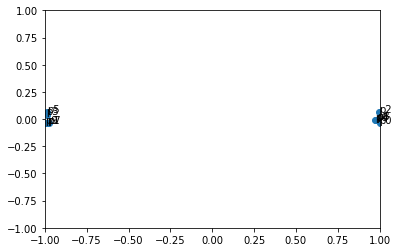

In [69]:
# Example data
vectors = [np.random.randn(10) * 0.1 + (i % 2) * 3 for i in range(10)]
names = [f'p{i}' for i in range(len(vectors))]

# Convert data to numpy array
vectors = np.array(vectors)

# Apply t-SNE for dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# vectors_tsne = tsne.fit_transform(vectors)

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

_scalar = np.max(np.abs(vectors_2d)) + 1e-9
vectors_2d /= _scalar

# Create the scatter plot
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

# Add labels for each point
for i, name in enumerate(names):
    plt.annotate(name, (vectors_2d[i, 0], vectors_2d[i, 1]))

# Show the plot
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()


In [ ]:
vectors

In [ ]:
vectors_2d, _scalar

### Actual inspection 
- For now, using the first tok representation for each node

In [74]:
ex_id = 111
a_ex_id = 0

ex = processed_spider_dev[ex_id]
ex['text_in'], \
ex['struct_in'], \
ex['seq_out']

('What is the accelerate of the car make amc hornet sportabout (sw)?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker ( amc ) , fullname , country | model_list : modelid , maker , model ( amc ) | car_names : makeid , model ( amc ) , make ( amc hornet , amc hornet sportabout (sw) ) | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';")

In [84]:
a_ex_col_list = ctu.create_analysis_sample_dicts(
                    mt_uskg, ex,
                    subject_type='column',
                    remove_struct_duplicate_nodes=True)
a_ex_tab_list = ctu.create_analysis_sample_dicts(
                    mt_uskg, ex,
                    subject_type='table',
                    remove_struct_duplicate_nodes=True)
a_ex_list = a_ex_col_list + a_ex_tab_list

In [85]:
a_ex = a_ex_list[0]

In [86]:
a_ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out', 'enc_sentence', 'enc_tokenized', 'text_range', 'struct_range', 'struct_node_ranges_dict', 'dec_prompt', 'expect', 'expect_type', 'remove_struct_duplicate_nodes', 'parsed_struct_in', 'col2table', 'token_ranges_dict', 'node_name_ranges', 'expect_input_ranges', 'alias2table', 'self_ranges', 'context_ranges', 'category'])

In [100]:
a_ex['expect_input_ranges']

[(178, 179)]

In [96]:
a_ex['seq_out']

"select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';"

In [89]:
occ_cols = [d['expect'] for d in a_ex_col_list]
occ_tabs = [d['expect'] for d in a_ex_tab_list]
occ_cols, occ_tabs

(['accelerate', 'makeid', 'make'], ['cars_data', 'car_names'])

In [93]:
col_name_ranges = a_ex['struct_node_ranges_dict']['col_name_ranges']
table_name_ranges = a_ex['struct_node_ranges_dict']['table_name_ranges']

non_occ_cols = [col for col in col_name_ranges
                    if (col not in occ_cols) and (len(col_name_ranges[col]) == 1)]
non_occ_tabs = [tab for tab in table_name_ranges
                    if (tab not in occ_tabs) and (len(table_name_ranges[tab]) == 1)]
non_occ_cols, non_occ_tabs

(['contid',
  'countryid',
  'countryname',
  'fullname',
  'country',
  'modelid',
  'mpg',
  'cylinders',
  'edispl',
  'horsepower',
  'weight',
  'year'],
 ['continents', 'countries', 'car_makers', 'model_list'])

In [99]:
a_ex['token_ranges_dict']

{'db_id_ranges': defaultdict(list, {'car_1': [(29, 32)]}),
 'table_name_ranges': defaultdict(list,
             {'continents': [(33, 35)],
              'countries': [(44, 45)],
              'car_makers': [(58, 61)],
              'model_list': [(82, 85)],
              'car_names': [(102, 106)],
              'cars_data': [(146, 149)]}),
 'col_name_ranges': defaultdict(list,
             {'contid': [(37, 40)],
              'continent': [(42, 43), (56, 57)],
              'countryid': [(47, 50)],
              'countryname': [(52, 54)],
              'id': [(63, 66), (151, 154)],
              'maker': [(68, 74), (92, 93)],
              'fullname': [(76, 78)],
              'country': [(80, 81)],
              'modelid': [(87, 90)],
              'model': [(95, 101), (113, 119)],
              'makeid': [(108, 111)],
              'make': [(121, 145)],
              'mpg': [(156, 159)],
              'cylinders': [(161, 164)],
              'edispl': [(166, 170)],
              'hor

In [128]:
# Dict[tok_id, part(enc/dec), name]
trace_positions = []

random.seed(42)

_occ_cols = random.sample(a_ex_col_list, k=2)

for d in _occ_cols:
    col = d['expect']
    assert len(d['expect_input_ranges']) == 1, d['expect_input_ranges']
    col_range = d['expect_input_ranges'][0]
    dec_prompt = d['dec_prompt']
    dec_prompt_len = len(mt_uskg.tokenizer.tokenize(dec_prompt, add_special_tokens=False))
    
    trace_positions.append({
        'tok_id': col_range[0],  # first tok 
        'part': 'encoder',
        'name': f'ENC-Y-COL::{col}',
    })
    trace_positions.append({
        'tok_id': dec_prompt_len,  # dec_prompt pos in dec seq 
        'part': 'decoder',
        'name': f'DEC-COL::{col}',
    })

_non_occ_cols = random.sample(non_occ_cols, k=2)

for col in _non_occ_cols:
    col_ranges = d['token_ranges_dict']['col_name_ranges'][col]
    assert len(col_ranges) == 1, (col, col_ranges)
    col_range = col_ranges[0]
    
    trace_positions.append({
        'tok_id': col_range[0],  # first tok 
        'part': 'encoder',
        'name': f'ENC-N-COL::{col}',
    })

## TODO: tables 


In [129]:
trace_positions

[{'tok_id': 121, 'part': 'encoder', 'name': 'ENC-Y-COL::make'},
 {'tok_id': 41, 'part': 'decoder', 'name': 'DEC-COL::make'},
 {'tok_id': 178, 'part': 'encoder', 'name': 'ENC-Y-COL::accelerate'},
 {'tok_id': 4, 'part': 'decoder', 'name': 'DEC-COL::accelerate'},
 {'tok_id': 37, 'part': 'encoder', 'name': 'ENC-N-COL::contid'},
 {'tok_id': 80, 'part': 'encoder', 'name': 'ENC-N-COL::country'}]

In [106]:
print(mt_uskg.tokenizer.tokenize(a_ex['seq_out'], add_special_tokens=False))

['▁select', '▁', 't', '1.', 'acc', 'ele', 'rate', '▁from', '▁cars', '_', 'data', '▁as', '▁', 't', '1', '▁join', '▁car', '_', 'name', 's', '▁as', '▁', 't', '2', '▁on', '▁', 't', '1.', 'i', 'd', '▁=', '▁', 't', '2.', 'make', 'i', 'd', '▁where', '▁', 't', '2.', 'make', '▁=', '▁', "'", 'am', 'c', '▁', 'horn', 'e', 't', '▁sport', 'about', '▁(', 's', 'w', ')', "'", ';']


In [122]:
enc_sentence = a_ex['enc_sentence']

seq_out = a_ex['seq_out']  ## Use the full decoder input 

# expect = a_ex['expect']
expect = '</s>'

bsz = 2

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * bsz,
    [seq_out] * bsz,
    answer=expect)

In [148]:
inp['input_ids'].size()

torch.Size([2, 183])

In [185]:
part2kinds = {
    'encoder': ['self_attn', 'mlp'],
    'decoder': ['self_attn', 'cross_attn', 'mlp'],
}

kind2projs = {
    'self_attn': ['.q', '.k', '.v', '.o', ''],
    'cross_attn': ['.q', '.k', '.v', '.o', ''],
    'mlp': [''],
}

kind2abbr = {
    'self_attn': 'SA',
    'cross_attn': 'XA',
    'mlp': 'MLP',
}

In [168]:
inspect_layer_ids = [0, 4, 8, 12, 16, 20, 23]

enc_inspect_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, kind) + proj
                      for l in inspect_layer_ids
                      for kind in part2kinds['encoder']
                      for proj in kind2projs[kind]] + \
                    ['control_trans_enc']

dec_inspect_layers = [ctu.layername_uskg(mt_uskg.model, 'decoder', l, kind) + proj
                      for l in inspect_layer_ids
                      for kind in part2kinds['decoder']
                      for proj in kind2projs[kind]] + \
                    ['control_trans', 'control_trans_dec']

inspect_layers = enc_inspect_layers + dec_inspect_layers

with torch.no_grad(), nethook.TraceDict(
    mt_uskg.model,
    layers=inspect_layers,
    edit_output=None,
) as td:
    outputs_exp = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [170]:
# each object.output = hidden, attn_weights 
list(td.keys())[-20:]

['pretrain_model.decoder.block.20.layer.1.EncDecAttention',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.q',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.k',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.v',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention.o',
 'pretrain_model.decoder.block.23.layer.0.SelfAttention',
 'pretrain_model.decoder.block.23.layer.1.EncDecAttention.q',
 'pretrain_model.decoder.block.23.layer.1.EncDecAttention.k',
 'pretrain_model.decoder.block.23.layer.1.EncDecAttention.v',
 'pretrain_model.decoder.block.23.layer.1.EncDecAttention.o',
 'pretrain_model.decoder.block.23.layer.1.EncDecAttention',
 'pretrain_model.decoder.block.0.layer.2.DenseReluDense',
 'pretrain_model.decoder.block.4.layer.2.DenseReluDense',
 'pretrain_model.decoder.block.8.layer.2.DenseReluDense',
 'pretrain_model.decoder.block.12.layer.2.DenseReluDense',
 'pretrain_model.decoder.block.16.layer.2.DenseReluDense',
 'pretrain_model.decoder.block.20.layer.2.

In [173]:
# _t = td['pretrain_model.encoder.block.8.layer.0.SelfAttention.v']
_t = td['control_trans_enc']
untuple(_t.output).size()
# for _k, _t in td.items():
#     print(_k, untuple(_t.output).size())

torch.Size([2, 10, 49152])

In [164]:
mt_uskg.model.pretrain_model.encoder.block[8].layer[0].SelfAttention.k

Linear(in_features=1024, out_features=1024, bias=False)

In [ ]:
mt_uskg.model.pretrain_model.config

In [182]:
bsz = 2
seqlen = mt_uskg.model.preseqlen
match_n_layer = 24
match_n_head = 16
match_n_embd = 64

past_key_values = untuple(td['control_trans_enc'].output)
# past_key_values = past_key_values.view(bsz, seqlen, match_n_layer * 2, match_n_head, match_n_embd)
# past_key_values = past_key_values.permute([2, 0, 3, 1, 4])
past_key_values = past_key_values.view(bsz, seqlen, match_n_layer * 2, match_n_head * match_n_embd)
past_key_values = past_key_values.permute([2, 0, 1, 3]).split(2)

## (kv, bsz, prefix_len, n_head * d_kv)
[t.size() for t in past_key_values]

[torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024]),
 torch.Size([2, 2, 10, 1024])]

In [239]:
all_vectors = []
all_names = []

for l_id in inspect_layer_ids:
    for trace_pos_d in trace_positions:
        tok_id = trace_pos_d['tok_id']
        part = trace_pos_d['part']
        name = trace_pos_d['name']
        
        for kind in part2kinds[part]:
            for proj in kind2projs[kind]:
                layer_name = ctu.layername_uskg(mt_uskg.model, part, l_id, kind) + proj
                layer_hidden = untuple(td[layer_name].output)
                vec = layer_hidden[0, tok_id].cpu().numpy()

                all_vectors.append(vec)
                all_names.append(f'{name}::L{l_id}.{kind2abbr[kind]}{proj}')

In [240]:
len(all_vectors), len(all_names)

(322, 322)

In [241]:
# prefix 

prefix_layer2abbr = {
    'control_trans': 'DEC-PFX-XA',
    'control_trans_enc': 'ENC-PFX-SA',
    'control_trans_dec': 'DEC-PFX-SA',
}

preseqlen = mt_uskg.model.preseqlen
match_n_layer = 24
match_n_head = 16
match_n_embd = 64

for pfx_lname, pfx_abbr in prefix_layer2abbr.items():
    past_key_values = untuple(td[pfx_lname].output)
    past_key_values = past_key_values.view(bsz, preseqlen, match_n_layer * 2, match_n_head * match_n_embd)
    past_key_values = past_key_values.permute([2, 0, 1, 3]).split(2)
    for l_id in inspect_layer_ids:
        # (kv, bsz, preseqlen, n_head * d_kv)
        kv_vecs = past_key_values[l_id]
        k_vecs = kv_vecs[0, 0].cpu().numpy()
        v_vecs = kv_vecs[1, 0].cpu().numpy()
        for pfx_pos in range(preseqlen):
            all_vectors.append(k_vecs[pfx_pos])
            all_names.append(f'{pfx_abbr}::#{pfx_pos}::L{l_id}.k')
            all_vectors.append(v_vecs[pfx_pos])
            all_names.append(f'{pfx_abbr}::#{pfx_pos}::L{l_id}.v')


In [242]:
len(all_vectors), len(all_names)

(742, 742)

In [ ]:
all_names

In [281]:
vectors, names = zip(*[(v, n) for v, n in zip(all_vectors, all_names)
                       if (n.startswith('ENC'))
                       and (n.endswith('.q') or n.endswith('.k'))
#                        and ('L12' in n)
#                        if not (n.startswith('DEC') and (n.endswith('L20') or n.endswith('L23')))
                      ])

In [282]:
len(vectors), len(names)

(126, 126)

In [283]:
names

('ENC-Y-COL::make::L0.SA.q',
 'ENC-Y-COL::make::L0.SA.k',
 'ENC-Y-COL::accelerate::L0.SA.q',
 'ENC-Y-COL::accelerate::L0.SA.k',
 'ENC-N-COL::contid::L0.SA.q',
 'ENC-N-COL::contid::L0.SA.k',
 'ENC-N-COL::country::L0.SA.q',
 'ENC-N-COL::country::L0.SA.k',
 'ENC-Y-COL::make::L4.SA.q',
 'ENC-Y-COL::make::L4.SA.k',
 'ENC-Y-COL::accelerate::L4.SA.q',
 'ENC-Y-COL::accelerate::L4.SA.k',
 'ENC-N-COL::contid::L4.SA.q',
 'ENC-N-COL::contid::L4.SA.k',
 'ENC-N-COL::country::L4.SA.q',
 'ENC-N-COL::country::L4.SA.k',
 'ENC-Y-COL::make::L8.SA.q',
 'ENC-Y-COL::make::L8.SA.k',
 'ENC-Y-COL::accelerate::L8.SA.q',
 'ENC-Y-COL::accelerate::L8.SA.k',
 'ENC-N-COL::contid::L8.SA.q',
 'ENC-N-COL::contid::L8.SA.k',
 'ENC-N-COL::country::L8.SA.q',
 'ENC-N-COL::country::L8.SA.k',
 'ENC-Y-COL::make::L12.SA.q',
 'ENC-Y-COL::make::L12.SA.k',
 'ENC-Y-COL::accelerate::L12.SA.q',
 'ENC-Y-COL::accelerate::L12.SA.k',
 'ENC-N-COL::contid::L12.SA.q',
 'ENC-N-COL::contid::L12.SA.k',
 'ENC-N-COL::country::L12.SA.q',
 'ENC-N-C

/home/yshao/anaconda3/envs/rome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yshao/anaconda3/envs/rome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/yshao/anaconda3/envs/rome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


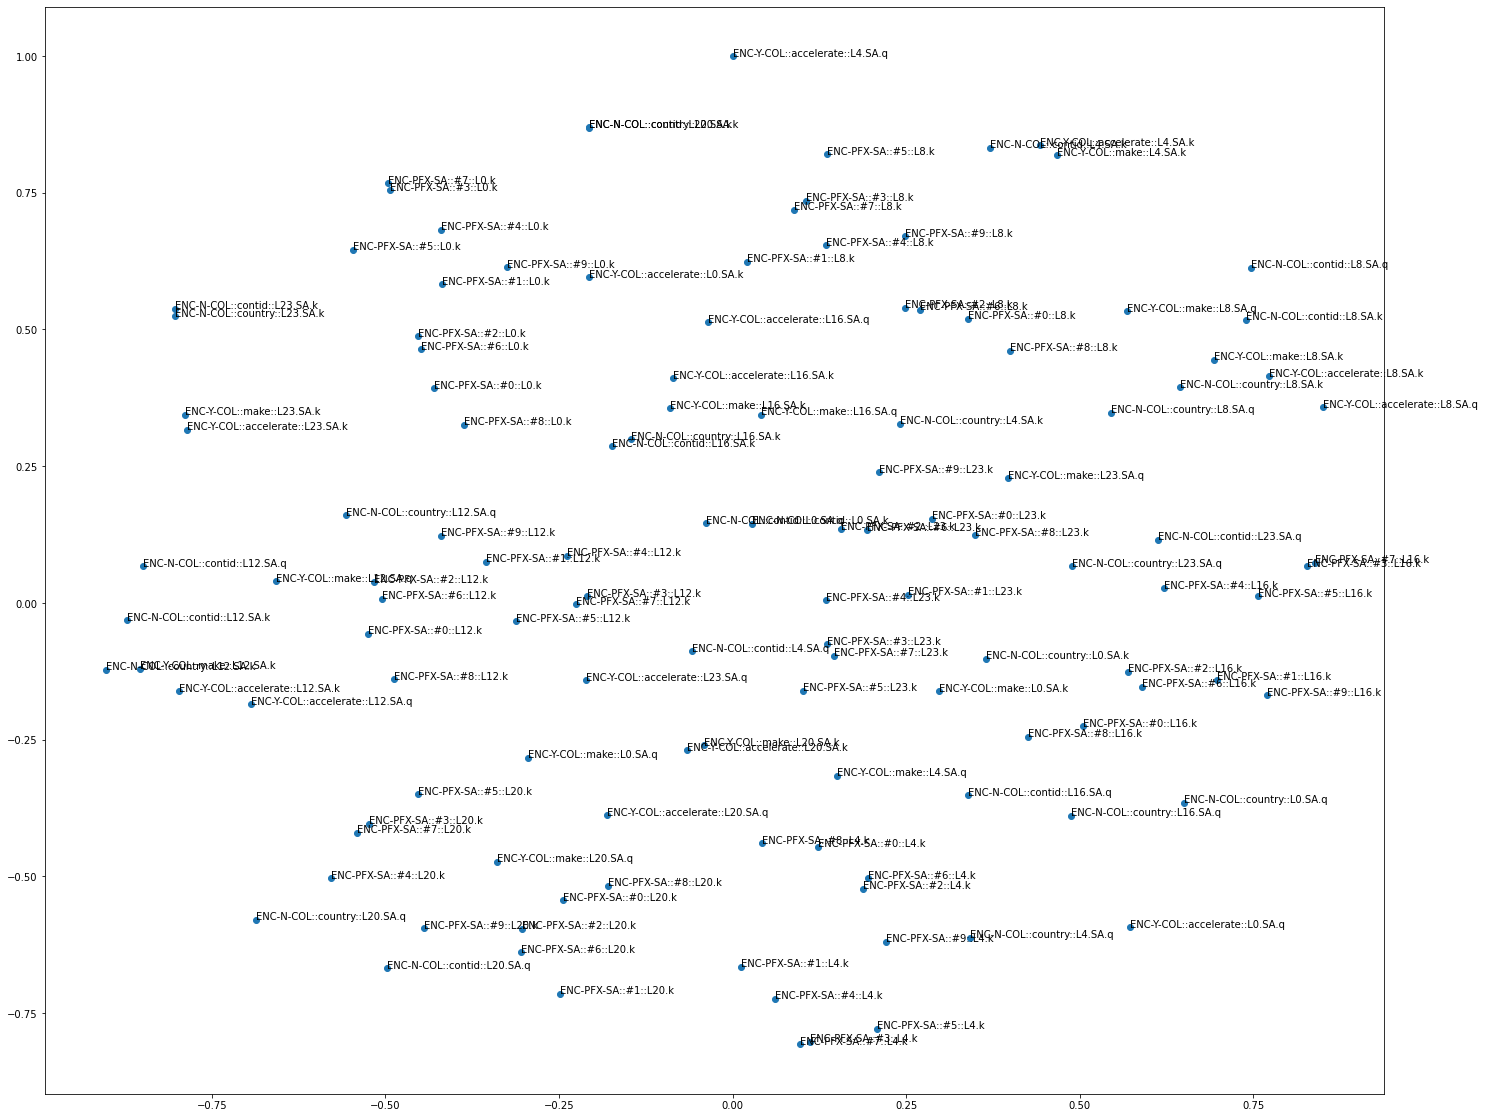

In [284]:
# Convert data to numpy array
vectors = np.array(vectors)

# Apply dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, metric=lambda x, y: 1 - np.dot(x, y))
vectors_2d = tsne.fit_transform(vectors)

# pca = PCA(n_components=2)
# vectors_2d = pca.fit_transform(vectors)

_scalar = np.max(np.abs(vectors_2d)) + 1e-9
vectors_2d /= _scalar

# Create the scatter plot
fig = plt.figure(figsize=(24, 20))
ax = fig.gca()

ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

zoom_x = 1.0
zoom_y = 1.0

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (vectors_2d[i, 0], vectors_2d[i, 1]))
# + np.random.uniform(-zoom_y * 0.03, zoom_y * 0.03)

# Show the plot
# ax.set_xlim(-zoom_x, zoom_x)
# ax.set_ylim(-zoom_y, zoom_y)
fig.show()


In [ ]:
# np.dot()

## Temp

### One-time patch

In [496]:
# # expect_type = 'table_alias'
# orig_res_path = f'/home/yshao/Projects/rome/results/exp6_2_decoder_cross_attention_corruption_syntax/no_o_exp=6.2_dev_corrupt=zero.jsonl'
# add_res_path = f'/home/yshao/Projects/rome/results/exp6_2_decoder_cross_attention_corruption_syntax/exp=6.2+o_dev_corrupt=zero.jsonl'

# merge_res_path = f'/home/yshao/Projects/rome/results/exp6_2_decoder_cross_attention_corruption_syntax/exp=6.2_dev_corrupt=zero.jsonl'

In [497]:
# with open(orig_res_path, 'r') as f:
#     orig_all_samples = [json.loads(l) for l in f]
# with open(add_res_path, 'r') as f:
#     add_all_samples = [json.loads(l) for l in f]

# f = open(merge_res_path, 'w')

# for i, (orig_ex, add_ex) in enumerate(zip(orig_all_samples, add_all_samples)):
#     assert len(orig_ex['trace_results']) == len(add_ex['trace_results']), i
#     # There is randomness in the order of expected node (from set()), thus sorting here 
#     orig_ex['trace_results'].sort(key=lambda d: len(d['dec_prompt']))
#     add_ex['trace_results'].sort(key=lambda d: len(d['dec_prompt']))
#     for j, (orig_d, add_d) in enumerate(zip(orig_ex['trace_results'], add_ex['trace_results'])):
#         assert orig_d['is_good_sample'] == add_d['is_good_sample'], (i, j)
#         if not orig_d['is_good_sample']:
#             continue
            
#         # is good sample: add the new sections 
#         for k, v in add_d['trace_scores'].items():
#             if k in orig_d['trace_scores']:
#                 continue
#             orig_d['trace_scores'][k] = add_d['trace_scores'][k]
        
#     f.write(json.dumps(orig_ex, indent=None) + '\n')
    
# f.close()

### Debugging exp

In [497]:
ex = processed_spider_dev[97]
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from"
expect = "car_names"

In [498]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence]*11,
    dec_prompts=[dec_prompt]*11,
    answer=expect
)

### RE

In [70]:
seq = 'aa,bb< cc  \t dd(  )ee <= ff=5 %h% "06-15".'
sep_pattern = r'\s+|\W'

all_matches = re.finditer(sep_pattern, seq)

In [71]:
all_matches = list(all_matches)
all_matches

[<re.Match object; span=(2, 3), match=','>,
 <re.Match object; span=(5, 6), match='<'>,
 <re.Match object; span=(6, 7), match=' '>,
 <re.Match object; span=(9, 13), match='  \t '>,
 <re.Match object; span=(15, 16), match='('>,
 <re.Match object; span=(16, 18), match='  '>,
 <re.Match object; span=(18, 19), match=')'>,
 <re.Match object; span=(21, 22), match=' '>,
 <re.Match object; span=(22, 23), match='<'>,
 <re.Match object; span=(23, 24), match='='>,
 <re.Match object; span=(24, 25), match=' '>,
 <re.Match object; span=(27, 28), match='='>,
 <re.Match object; span=(29, 30), match=' '>,
 <re.Match object; span=(30, 31), match='%'>,
 <re.Match object; span=(32, 33), match='%'>,
 <re.Match object; span=(33, 34), match=' '>,
 <re.Match object; span=(34, 35), match='"'>,
 <re.Match object; span=(37, 38), match='-'>,
 <re.Match object; span=(40, 41), match='"'>,
 <re.Match object; span=(41, 42), match='.'>]

In [72]:
all_matches[0].span()

(2, 3)

In [73]:
splits = [0] + [i for m in all_matches for i in m.span()] + [len(seq)]
splits = sorted(list(set(splits)))
print(splits)

[0, 2, 3, 5, 6, 7, 9, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42]


In [74]:
st = 0
SP = ["<=", ">=", "<>", "!="]
toks = []

for s, e in zip(splits[:-1], splits[1:]):
    if not seq[s:e].strip():
        # is a whitespace
        st = e
    else:
        # is a punct
        if seq[s:s+2] in SP:
            # wait next
            continue
        toks.append(seq[st:e])
        st = e
        

In [75]:
print(toks)

['aa', ',', 'bb', '<', 'cc', 'dd', '(', ')', 'ee', '<=', 'ff', '=', '5', '%', 'h', '%', '"', '06', '-', '15', '"', '.']


### other temp

In [311]:
mt_uskg.tokenizer.tokenize('school_name')

['▁school', '_', 'name']

In [183]:
torch.zeros(6,8,10).split(2)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [ ]:
torch.split()

## (placeholder)